# Import numpy and set random seed

In [ ]:
import numpy as np
# random seed so that results are reproducible
rs = 1234
np.random.seed(rs)

# Download the mnist dataset from tensorflow datasets and view an image

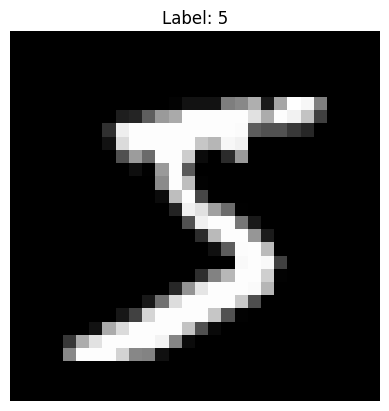

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

y_train = train_labels
y_test = test_labels

def show_img_at_index(index):
  plt.imshow(train_images[index], cmap='gray')
  plt.title(f'Label: {train_labels[index]}')
  plt.axis('off')
  plt.show()

show_img_at_index(0)

# Reshape the dataset

In [ ]:
# Normalize the pixel values to a range of 0 to 1
train_images = train_images / 255.0
test_images = test_images / 255.0
print('Shape of train_images:', train_images.shape)
print('Shape of test_images:', test_images.shape)

# Flatten the images from a 2D grid to a 1D array for feeding into the neural network
X_train = train_images.reshape((-1, 28 * 28))
X_test = test_images.reshape((-1, 28 * 28))

print('Shape of train dataset:', X_train.shape)
print('Shape of test dataset:', X_test.shape)

Shape of train_images: (60000, 28, 28)
Shape of test_images: (10000, 28, 28)
Shape of train dataset: (60000, 784)
Shape of test dataset: (10000, 784)


# Make batches from the dataset

In [ ]:
# Split the training data into batches
def make_batches(X, y, batch_size):
  train_data_batches = []
  for i in range(0, len(X_train), batch_size):
    batch_data = X_train[i:i + batch_size]
    batch_labels = y_train[i:i + batch_size]  # Assuming you have labels y_train
    train_data_batches.append((batch_data, batch_labels))
  return train_data_batches

train_data_batched = make_batches(X_train, y_train, batch_size=64)
# Check if the batches were made correctly:
print('Number of batches in train dataset:', len(train_data_batched))
for batch_idx, (batch_data, batch_labels) in enumerate(train_data_batched):
    print(f'Shape of batch {batch_idx}: Data - {batch_data.shape}, Labels - {batch_labels.shape}')
    if batch_idx == 5:
      break

test_data_batched = make_batches(X_test, y_test, batch_size=64)

Number of batches in train dataset: 938
Shape of batch 0: Data - (64, 784), Labels - (64,)
Shape of batch 1: Data - (64, 784), Labels - (64,)
Shape of batch 2: Data - (64, 784), Labels - (64,)
Shape of batch 3: Data - (64, 784), Labels - (64,)
Shape of batch 4: Data - (64, 784), Labels - (64,)
Shape of batch 5: Data - (64, 784), Labels - (64,)


# Implement the Neural Network's Dense Layer

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
class Dense:
  def __init__(self, num_inputs, num_units, activation='linear'):
    self.W = np.random.randn(num_inputs, num_units) # from a std normal distribution
    self.b = np.random.randn(1, num_units)
    self.activation = activation

  def forward(self, input_data):
    self.input = input_data # store for backpropagation
    self.output = np.dot(self.input, self.W) + self.b
    if self.activation == 'linear':
      return self.output
    elif self.activation == 'relu':
      self.output = np.maximum(0, self.output)
    elif self.activation == 'tanh':
      self.output = np.tanh(self.output)
    elif self.activation == 'sigmoid':
      self.output = sigmoid(self.output)
    return self.output

  def backward(self, grad, lr):
    # grad is the backpropagation signal being sent through in a chain reaction backwards,
    # after being calculated once at the final layer w.r.t the Loss Function
    self.dW = np.dot(self.input.T, grad)
    self.db = np.sum(grad, axis=0, keepdims=True)
    # axis and keepdims are specified so that calculations are broadcasted correctly
    self.grad = np.dot(grad, self.W.T)
    # grad is the self.grad of the next layer to this one's hence why its coming in as an argument
    self.W = self.W - lr * self.dW
    self.b = self.b - lr * self.db
    if self.activation == 'linear':
      return self.grad
    elif self.activation == 'relu':
      self.grad = (self.input > 0).astype(np.float32) * self.grad
    elif self.activation == 'tanh':
      self.grad = (1 - np.tanh(self.input) ** 2) * self.grad
    elif self.activation == 'sigmoid':
      self.grad = sigmoid(self.input) * (1 - sigmoid(self.input)) * self.grad
    return self.grad

# Softmax function implementation

In [ ]:
def softmax(x):
  # return an array where each element is the predicted probability for each label
  exps = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exps / np.sum(exps, axis=1, keepdims=True)

# Make and train the Neural Network

In [ ]:
input_size = 784  # 28x28 images flattened to 784
hidden_size = 128
output_size = 10  # 10 classes for MNIST (0-9)

layer1 = Dense(input_size, hidden_size, activation='relu')
layer2 = Dense(hidden_size, output_size, activation='linear')

# Training loop
epochs = 30
learning_rate = 0.01

for epoch in range(epochs):
  error = 0
  for batch_idx, (batch_data, batch_labels) in enumerate(train_data_batched):
    # Forward pass
    out_layer1 = layer1.forward(batch_data)
    out_layer2 = layer2.forward(out_layer1)

    # for each image in the batch, get an array where each element is the predicted probability for each of the 10 labels:
    probs = softmax(out_layer2)
    # extract the predicted probabilities of the correct labels for each image in the batch then find the mean
    # negative log-likelihood loss for the batch
    loss = -np.log(probs[range(len(batch_labels)), batch_labels]).mean()

    error += loss

    # Backpropagation
    grad_softmax = probs
    # To reduce the loss, the model will produce higher probabilities for the correct labels
    # because we are only subtracting 1 for the correct labels' predicted probabilities
    grad_softmax[range(len(batch_labels)), batch_labels] -= 1
    # normalize the gradient so that the model training is independent of number of samples available in the dataset
    grad_softmax /= len(batch_labels)

    grad_layer2 = layer2.backward(grad_softmax, learning_rate)
    grad_layer1 = layer1.backward(grad_layer2, learning_rate)

  print(f"Epoch {epoch + 1}: Training error {error}")

Epoch 1: Training error 10708.32855996029
Epoch 2: Training error 4327.948229581004
Epoch 3: Training error 3355.949713344687
Epoch 4: Training error 2816.4055144470553
Epoch 5: Training error 2453.4333550345104
Epoch 6: Training error 2183.5501635002
Epoch 7: Training error 1969.8855321800406
Epoch 8: Training error 1794.6573504457854
Epoch 9: Training error 1647.6584499715084
Epoch 10: Training error 1522.114707721464
Epoch 11: Training error 1413.563596551184
Epoch 12: Training error 1318.6393523991364
Epoch 13: Training error 1234.5211536596717
Epoch 14: Training error 1159.3895080225172
Epoch 15: Training error 1091.640573210546
Epoch 16: Training error 1030.3501511292998
Epoch 17: Training error 974.6898572126223
Epoch 18: Training error 923.872787094477
Epoch 19: Training error 877.3994925563787
Epoch 20: Training error 834.7382653323964
Epoch 21: Training error 795.45324329651
Epoch 22: Training error 759.1951047764146
Epoch 23: Training error 725.6196284353541
Epoch 24: Traini

# Test the trained Neural Network on the test datset

In [ ]:
correct_predictions = 0
total_samples = 0
error = 0
for batch_idx, (batch_data, batch_labels) in enumerate(test_data_batched):
  # Forward pass
  out_layer1 = layer1.forward(batch_data)
  out_layer2 = layer2.forward(out_layer1)

  # Softmax and compute loss
  probs = softmax(out_layer2)
  loss = -np.log(probs[range(len(batch_labels)), batch_labels]).mean()

  error += loss

  # Calculations for finding accuracy of the model on the test dataset:
  predicted_labels = np.argmax(probs, axis=1)
  correct_predictions += np.sum(predicted_labels == batch_labels)
  total_samples += len(batch_labels)

accuracy = round(correct_predictions / total_samples * 100, 2)
print(f"Test error:    {error}")
print(f"Test accuracy: {accuracy}%")

Test error:    541.6574473726172
Test accuracy: 90.22%


# Visualize the predictions made by the model in a subplot

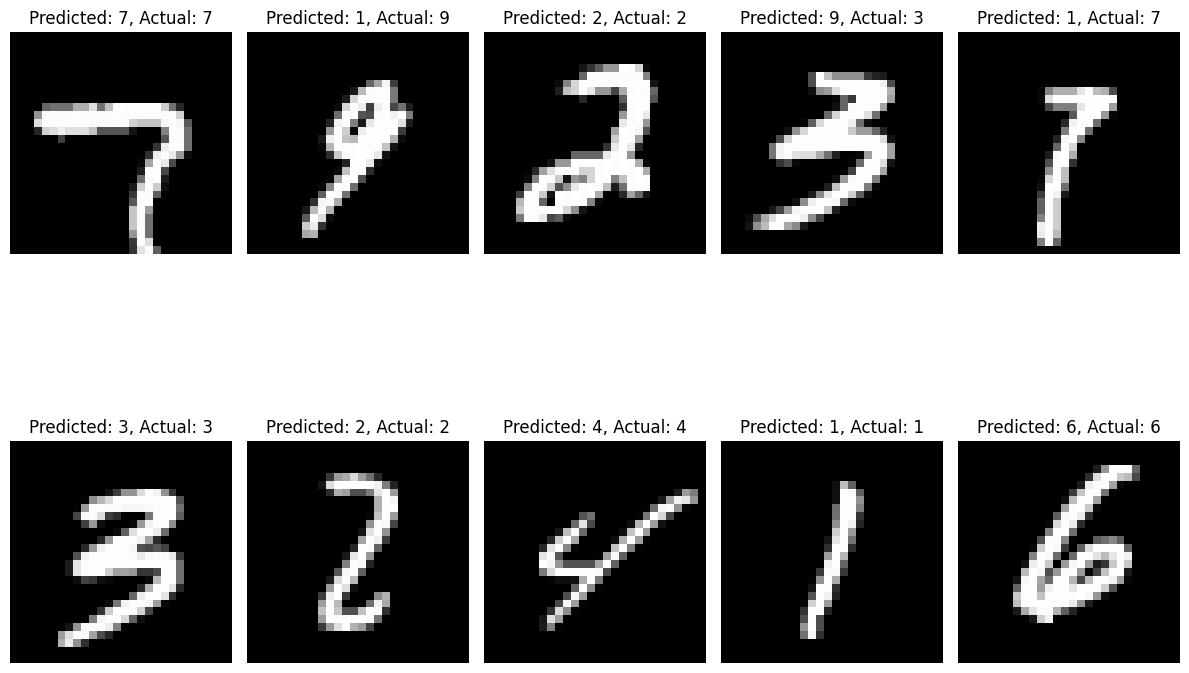

In [ ]:
def visualize_batch_predictions(batch_data, predicted_labels, batch_labels, num_samples_to_visualize, num_images_per_row):
  num_rows = int(np.ceil(num_samples_to_visualize / num_images_per_row))  # Assuming 5 images per row

  plt.figure(figsize=(12, 10))
  for i in range(num_samples_to_visualize):
    plt.subplot(num_rows, num_images_per_row, i + 1)  # Create subplots
    sample_image = batch_data[i].reshape(28, 28)  # Reshape the flattened image to its original shape
    plt.imshow(sample_image, cmap='gray')
    plt.title(f"Predicted: {predicted_labels[i]}, Actual: {batch_labels[i]}")
    plt.axis('off')

  plt.tight_layout()
  plt.show()

batch_idx = 10  # Choose the batch index for the batch that we want to visualize
num_samples_to_visualize = 10  # Number of samples to visualize from the batch, taken from the beginning of the batch
num_images_per_row = 5

batch_data, batch_labels = test_data_batched[batch_idx]

# Forward pass
out_layer1 = layer1.forward(batch_data)
out_layer2 = layer2.forward(out_layer1)

# Softmax and compute predictions
probs = softmax(out_layer2)
predicted_labels = np.argmax(probs, axis=1)

visualize_batch_predictions(batch_data, predicted_labels, batch_labels, num_samples_to_visualize, num_images_per_row)